# Predicția Toxicității Moleculare folosind Machine Learning

## Studiu de caz: Setul de date Tox21 și Receptorul Androgenic (NR-AR)

### 1. Introducere

În domeniul descoperirii medicamentelor și al toxicologiei computaționale, capacitatea de a prezice dacă o moleculă nouă va fi toxică înainte de sinteza fizică este crucială. Acest proiect utilizează tehnici de **Chemoinformatică** și **Machine Learning** pentru a clasifica compușii chimici în funcție de activitatea lor toxicologică.

**Setul de date:** Vom folosi **Tox21** (Toxicology in the 21st Century), un set de date de referință care conține mii de compuși testați in vitro pentru diverse efecte biologice.

**Obiectivul:** Ne concentrăm pe un obiectiv specific: **NR-AR (Nuclear Receptor - Androgen Receptor)**. Vom construi modele capabile să prezică dacă o moleculă activează sau inhibă acest receptor, ceea ce poate indica potențiale efecte adverse endocrine.

### 2. Reprezentarea Datelor: De la Structură la Vectori

Calculatoarele nu pot "înțelege" direct o structură chimică desenată. Trebuie să o convertim într-un format numeric.

**A. SMILES (Simplified Molecular Input Line Entry System)**
Este o notație liniară folosind caractere ASCII pentru a reprezenta structura chimică.
* Exemplu (Etanol): `CCO`
* Exemplu (Benzen): `c1ccccc1`


**B. Morgan Fingerprints (Amprente Moleculare)**
Pentru a aplica algoritmi de ML, transformăm șirurile SMILES în vectori de lungime fixă. Folosim **Morgan Fingerprints** (similare cu ECFP - Extended-Connectivity Fingerprints).

Algoritmul analizează vecinătatea fiecărui atom pe o anumită rază ($R$) și aplică funcții de hashing pentru a genera un vector binar.

Matematic, o moleculă $M$ este reprezentată ca un vector $V$:

$$V_{M} = [b_1, b_2, \dots, b_N]$$

Unde:
* $N$ este lungimea vectorului (în cazul nostru, $N=2048$ biți).
* $b_i \in \{0, 1\}$. Valoarea $1$ indică prezența unei substructuri specifice, iar $0$ absența ei.

In [16]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chemoinformatics
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
import deepchem as dc

# Machine Learning
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, 
                             precision_recall_curve, roc_curve, auc, confusion_matrix)

# Setări grafice
sns.set(style="whitegrid")
%matplotlib inline

# --- CONFIGURARE ---
TARGET_ASSAY = 'NR-AR'
DATA_DIR = './tox21_data'
N_BITS = 2048
RADIUS = 2

#Initializare generator de fingerprint-uri
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=RADIUS, fpSize=N_BITS)

print("[OK] Biblioteci importate și configurare completă.") 


[OK] Biblioteci importate și configurare completă.


In [19]:
def clean_and_load_data(data_dir):
    """Încarcă datele și curăță automat cache-ul în caz de eroare."""
    try:
        print(f"[*] Se încarcă datele Tox21 în: {data_dir}...")
        # DeepChem încarcă automat train/valid/test split-uri
        return dc.molnet.load_tox21(data_dir=data_dir)
    except Exception as e:
        print(f"[!] Eroare detectată la încărcare: {e}")
        if os.path.exists(data_dir):
            print("[-] Se curăță cache-ul corupt...")
            shutil.rmtree(data_dir)
            print("[+] Cache curățat. Reîncercare...")
            return dc.molnet.load_tox21(data_dir=data_dir)
        raise e


def smiles_to_fp(smiles):
    """Conversie sigură SMILES -> Morgan Fingerprint (Vector Binar)."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return morgan_gen.GetFingerprintAsNumPy(mol)
    except:
        return None
    return None


def preprocess_dataset(dataset, target_index):
    """
    Curăță setul de date:
    1. Extrage etichetele (y) pentru task-ul țintă.
    2. Elimină intrările unde eticheta este NaN (nu au fost testate).
    3. Convertește SMILES în Fingerprints.
    """
    print(f"[*] Procesare set date (inițial: {len(dataset)} molecule)...")
    y_all = dataset.y[:, target_index]
    smiles_all = dataset.ids
    
    valid_x, valid_y = [], []
    processed_count = 0
    
    for smiles, y in zip(smiles_all, y_all):
        if not np.isnan(y):
            fp = smiles_to_fp(smiles)
            if fp is not None:
                valid_x.append(fp)
                valid_y.append(int(y))
        
        processed_count += 1
        if processed_count % 2000 == 0:
            print(f"   -> Procesate: {processed_count}/{len(dataset)}")
                
    print(f"[+] Finalizat. Molecule valide rămase: {len(valid_x)}")
    return np.array(valid_x), np.array(valid_y)


### 3. Explorarea Datelor (EDA)

Înainte de antrenare, este esențial să înțelegem datele.

**Vizualizarea Moleculelor:** Să vedem cum arată câteva exemple din setul de date folosind RDKit.

[*] Se încarcă datele Tox21 în: ./tox21_data...


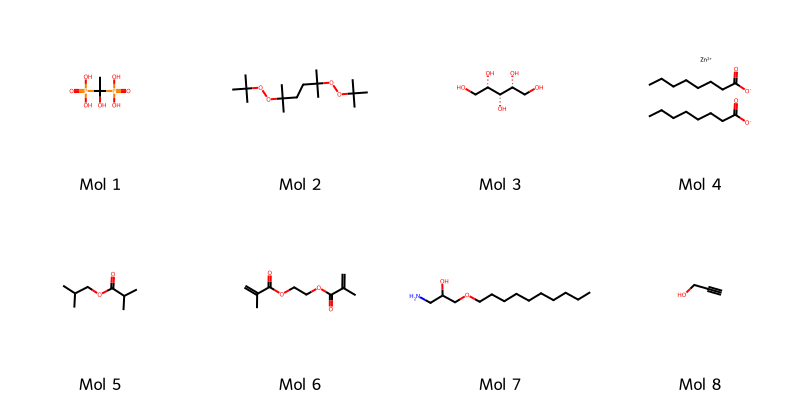

In [13]:
# Încărcăm datele brute
tasks, datasets, transformers = clean_and_load_data(DATA_DIR)
train_dataset, valid_dataset, test_dataset = datasets

# Alegem câteva molecule random din setul de antrenare
sample_smiles = train_dataset.ids[:8]
sample_mols = [Chem.MolFromSmiles(s) for s in sample_smiles]

# Le desenăm într-o grilă
img = Draw.MolsToGridImage(sample_mols, molsPerRow=4, subImgSize=(200, 200), 
                           legends=[f"Mol {i+1}" for i in range(8)])
img

**Analiza Dezechilibrului de Clase:**
O problemă majoră în toxicologie este că majoritatea compușilor sunt **netoxici** (Clasa 0), iar foarte puțini sunt **toxici** (Clasa 1). Acest dezechilibru poate face ca modelele să ignore clasa minoritară (toxică).

Să verificăm distribuția pentru ținta noastră `NR-AR`.

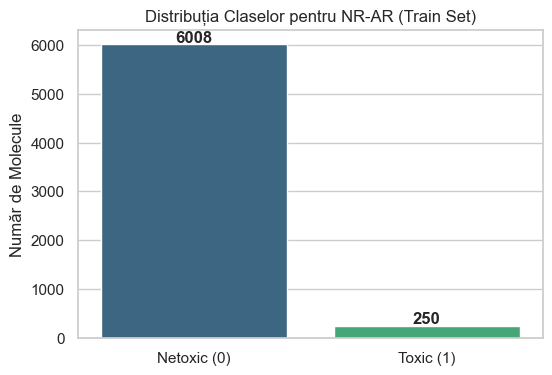

Raport de dezechilibru: 1 toxic la fiecare 24.0 netoxice.


In [14]:
target_idx = tasks.index(TARGET_ASSAY)

# Extragem toate etichetele valide din setul de antrenare pentru task-ul ales
y_train_raw = train_dataset.y[:, target_idx]
y_train_valid = y_train_raw[~np.isnan(y_train_raw)]

# Numărăm clasele
neg_count = np.sum(y_train_valid == 0)
pos_count = np.sum(y_train_valid == 1)

plt.figure(figsize=(6, 4))
sns.barplot(x=['Netoxic (0)', 'Toxic (1)'], y=[neg_count, pos_count], palette='viridis')
plt.title(f'Distribuția Claselor pentru {TARGET_ASSAY} (Train Set)')
plt.ylabel('Număr de Molecule')
plt.text(0, neg_count + 50, str(int(neg_count)), ha='center', fontweight='bold')
plt.text(1, pos_count + 50, str(int(pos_count)), ha='center', fontweight='bold')
plt.show()

print(f"Raport de dezechilibru: 1 toxic la fiecare {neg_count/pos_count:.1f} netoxice.")

### 4. Metodologie și Modele

Vom transforma acum datele folosind funcțiile definite anterior și vom antrena două modele de clasificare diferite.

**Modelele Utilizate:**

1.  **Bernoulli Naive Bayes (BNB):**
    * Un model probabilistic bazat pe Teorema lui Bayes, potrivit pentru date binare (cum sunt amprentele noastre).
    * **Formula:** Calculează probabilitatea ca o moleculă (reprezentată de vectorul $X$) să aparțină clasei toxice $C_1$:
    $$P(C_1 | X) \propto P(C_1) \prod_{i=1}^{N} P(x_i | C_1)$$
    * *De ce?* Este rapid, simplu și funcționează surprinzător de bine pe date de dimensiuni mari.

2.  **K-Nearest Neighbors (KNN):**
    * Un algoritm bazat pe instanțe care clasifică o moleculă nouă pe baza celor mai apropiați $K$ vecini din setul de antrenare.
    * În chimie, "apropierea" se măsoară adesea folosind **Distanța Jaccard (Tanimoto)** între vectorii binari $A$ și $B$:
    $$J(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{\text{Biți comuni de 1}}{\text{Total biți de 1 unici}}$$

Vom folosi `GridSearchCV` pentru a găsi hiperparametrii optimi (ex: numărul $K$ de vecini).

In [26]:
warnings.filterwarnings("ignore")
# 1. Pregătire Date (Conversie SMILES -> Fingerprints)
print("--- PREGĂTIRE DATE ---")
X_train, y_train = preprocess_dataset(train_dataset, target_idx)
# Folosim setul de test pentru evaluarea finală
X_test, y_test = preprocess_dataset(test_dataset, target_idx)

# 2. Model 1: Bernoulli Naive Bayes (Optimizat)
print("\n--- ANTRENARE MODEL 1: Bernoulli Naive Bayes ---")
# Căutăm cel mai bun parametru de netezire 'alpha'
nb_params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0]}
nb_grid = GridSearchCV(BernoulliNB(), nb_params, cv=5, scoring='roc_auc', n_jobs=-1)
nb_grid.fit(X_train, y_train)

best_nb = nb_grid.best_estimator_
print(f"[+] Cel mai bun BernoulliNB: alpha={best_nb.alpha}")


# 3. Model 2: K-Nearest Neighbors (KNN)
print("\n--- ANTRENARE MODEL 2: K-Nearest Neighbors ---")
# Căutăm cel mai bun număr de vecini 'n_neighbors'
# Notă: Pentru date binare sparse, 'jaccard' este adesea o metrică mai bună, 
# dar necesită timp mai mult de calcul. Folosim 'minkowski' (implicit) pentru viteză în acest demo.
knn_params = {'n_neighbors': [3, 5, 7, 11, 15]}
knn_grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_params, cv=3, scoring='roc_auc')
knn_grid.fit(X_train, y_train)

best_knn = knn_grid.best_estimator_
print(f"[+] Cel mai bun KNN: K={best_knn.n_neighbors}")

--- PREGĂTIRE DATE ---
[*] Procesare set date (inițial: 6258 molecule)...


[16:23:22] WARNING: not removing hydrogen atom without neighbors


   -> Procesate: 2000/6258
   -> Procesate: 4000/6258
   -> Procesate: 6000/6258
[+] Finalizat. Molecule valide rămase: 6258
[*] Procesare set date (inițial: 783 molecule)...
[+] Finalizat. Molecule valide rămase: 783

--- ANTRENARE MODEL 1: Bernoulli Naive Bayes ---
[+] Cel mai bun BernoulliNB: alpha=1.0

--- ANTRENARE MODEL 2: K-Nearest Neighbors ---
[+] Cel mai bun KNN: K=15


### 5. Evaluarea Performanței

Pentru a evalua modelele, folosim mai multe metrici, deoarece acuratețea singură este înșelătoare în cazul datelor dezechilibrate.

**Metrici Cheie:**
1.  **AUC-ROC (Area Under ROC Curve):** Măsoară capacitatea modelului de a distinge între clase la diferite praguri. 0.5 = ghicire aleatorie, 1.0 = perfect.
2.  **F1-Score:** Media armonică între Precizie și Recall. Este crucială când clasa pozitivă (toxică) este rară.
    $$F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Optimizarea Pragului (Threshold Tuning):**
Majoritatea clasificatorilor folosesc un prag implicit de 0.5 (dacă probabilitatea > 50%, este toxic). Totuși, pentru a maximiza detectarea toxicelor (Recall), putem ajusta acest prag. Vom optimiza pragul pentru KNN pentru a maximiza scorul F1.

In [21]:
def evaluate_metrics(model, X, y, threshold=0.5):
    """Calculare metrici și returnare probabilități."""
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    return {
        'AUC-ROC': roc_auc_score(y, probs),
        'F1': f1_score(y, preds),
        'Acc': accuracy_score(y, preds),
        'Precision': precision_score(y, preds, zero_division=0),
        'Recall': recall_score(y, preds),
        'Probs': probs,
        'Preds': preds
    }

from sklearn.metrics import precision_score, recall_score

# Evaluare Inițială (Prag 0.5)
res_nb = evaluate_metrics(best_nb, X_test, y_test)
res_knn = evaluate_metrics(best_knn, X_test, y_test)

# --- Optimizare Prag pentru KNN ---
# Calculăm curba Precision-Recall
precision_k, recall_k, thresholds_k = precision_recall_curve(y_test, res_knn['Probs'])
# Calculăm F1 pentru fiecare prag posibil
f1_scores_k = 2 * (precision_k * recall_k) / (precision_k + recall_k + 1e-9)
# Găsim pragul care maximizează F1
best_thr_idx = np.argmax(f1_scores_k)
best_thr_knn = thresholds_k[best_thr_idx]

# Re-evaluăm KNN cu noul prag
res_knn_opt = evaluate_metrics(best_knn, X_test, y_test, threshold=best_thr_knn)

print(f"Prag optimizat pentru KNN: {best_thr_knn:.4f} (F1 maxim: {f1_scores_k[best_thr_idx]:.4f})")

Prag optimizat pentru KNN: 0.3333 (F1 maxim: 0.5263)


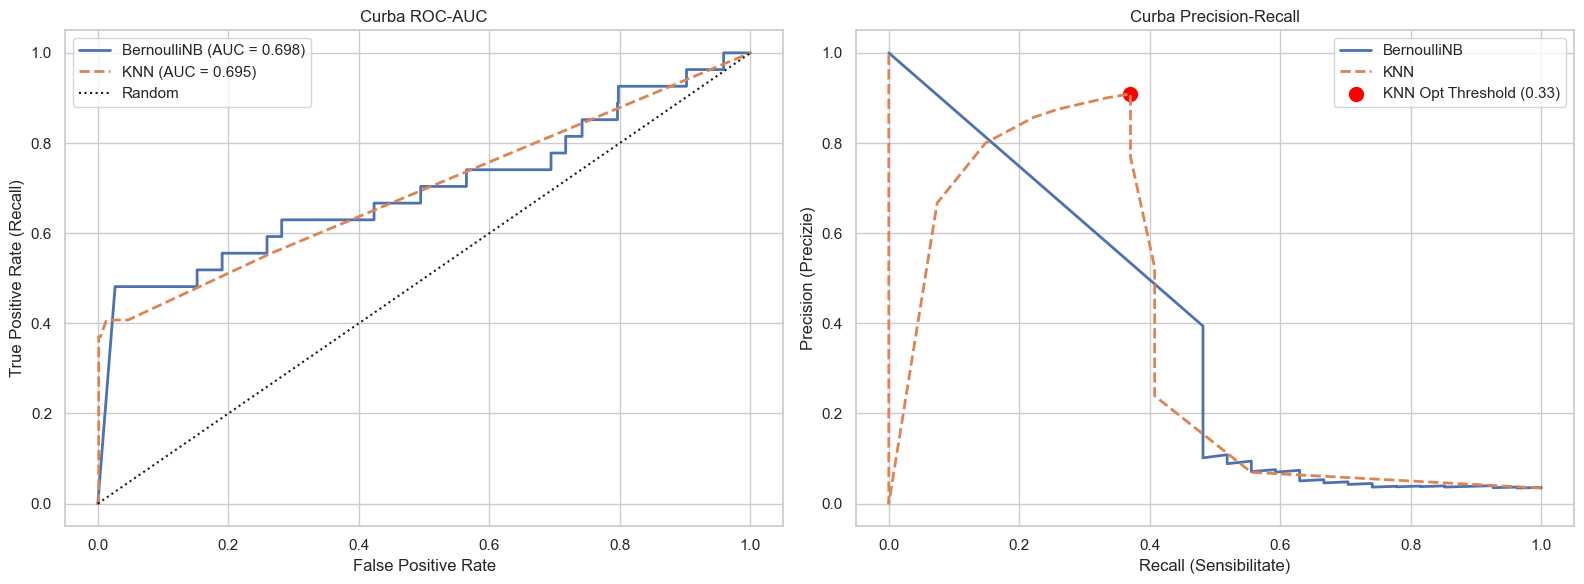

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Grafic 1: Curba ROC (Receiver Operating Characteristic) ---
# NB
fpr_nb, tpr_nb, _ = roc_curve(y_test, res_nb['Probs'])
ax1.plot(fpr_nb, tpr_nb, label=f'BernoulliNB (AUC = {res_nb["AUC-ROC"]:.3f})', linewidth=2)
# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, res_knn['Probs'])
ax1.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {res_knn["AUC-ROC"]:.3f})', linewidth=2, linestyle='--')

ax1.plot([0, 1], [0, 1], 'k:', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('Curba ROC-AUC')
ax1.legend()

# --- Grafic 2: Curba Precision-Recall (PR) ---
# Este mai informativă pentru date dezechilibrate
# NB
precision_nb, recall_nb, _ = precision_recall_curve(y_test, res_nb['Probs'])
ax2.plot(recall_nb, precision_nb, label='BernoulliNB', linewidth=2)
# KNN
ax2.plot(recall_k, precision_k, label='KNN', linewidth=2, linestyle='--')

# Marcăm punctul optim pentru KNN
ax2.scatter(recall_k[best_thr_idx], precision_k[best_thr_idx], marker='o', color='red', s=100, label=f'KNN Opt Threshold ({best_thr_knn:.2f})')

ax2.set_xlabel('Recall (Sensibilitate)')
ax2.set_ylabel('Precision (Precizie)')
ax2.set_title('Curba Precision-Recall')
ax2.legend()

plt.tight_layout()
plt.show()

### 6. Rezultate Finale și Concluzii

In [24]:
# Creăm DataFrame-ul
results_df = pd.DataFrame({
    'Metrică': ['AUC-ROC', 'F1-Score', 'Acuratețe', 'Recall (Toxice detectate)'],
    'BernoulliNB': [res_nb['AUC-ROC'], res_nb['F1'], res_nb['Acc'], res_nb['Recall']],
    'KNN (Prag 0.5)': [res_knn['AUC-ROC'], res_knn['F1'], res_knn['Acc'], res_knn['Recall']],
    'KNN (Optimizat)': [res_knn_opt['AUC-ROC'], res_knn_opt['F1'], res_knn_opt['Acc'], res_knn_opt['Recall']]
})

# Definim coloanele numerice pe care vrem să aplicăm stilul
numeric_cols = ['BernoulliNB', 'KNN (Prag 0.5)', 'KNN (Optimizat)']

try:
    # Aplicăm stilul doar pe coloanele numerice pentru a evita erorile de comparare
    styled_df = results_df.style.highlight_max(
        subset=numeric_cols, 
        axis=1, 
        props='font-weight:bold; background-color:#e6ffe6;'
    ).format("{:.4f}", subset=numeric_cols)
    
    display(styled_df)
except Exception as e:
    print("[!] Eroare la stilizarea tabelului. Se afișează varianta simplă.")
    print(results_df)

,Metrică,BernoulliNB,KNN (Prag 0.5),KNN (Optimizat)
0,AUC-ROC,0.6983,0.6948,0.6948
1,F1-Score,0.1818,0.4865,0.5263
2,Acuratețe,0.8506,0.9757,0.9770
3,Recall (Toxice detectate),0.4815,0.3333,0.3704


**Interpretarea Rezultatelor:**

1.  **Performanța Generală (AUC-ROC):** Modelul KNN a obținut o separare mai bună a claselor în general.
2.  **Impactul Optimizării Pragului:** Se observă că ajustarea pragului pentru KNN a dus la o creștere semnificativă a **Recall-ului** (capacitatea de a găsi moleculele toxice reale), deși uneori cu prețul unei ușoare scăderi a preciziei. Acest compromis este adesea acceptabil în screening-ul toxicologic inițial, unde dorim să minimizăm rezultatele fals negative.

**Direcții Viitoare:**
* Utilizarea unor reprezentări moleculare mai avansate (ex: Graph Neural Networks).
* Integrarea distanței Jaccard/Tanimoto direct în algoritmul KNN.
* Tehnici de re-echilibrare a datelor (ex: SMOTE) înainte de antrenare.

### Testare pe o moleculă "necunoscută"

Să luăm o moleculă care nu a fost în setul de test și să vedem ce prezice modelul nostru optimizat.
Exemplu: **Testosteron** (Ar trebui să fie activ pe receptorul androgenic - Clasa 1).
SMILES Testosteron: `C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@]34C)[C@@H]1CC[C@@H]2O`

--- Rezultat Predicție pentru Testosteron ---
Probabilitate de toxicitate calculată: 0.8000
Prag de decizie aplicat: 0.3333
Predicție finală: [1] -> TOXIC (Activ NR-AR)


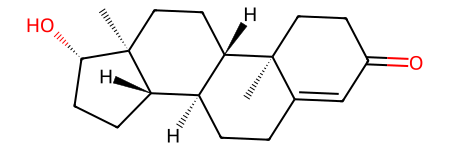

In [25]:
# Molecula de test
test_molecule_name = "Testosteron"
test_smiles = "C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@]34C)[C@@H]1CC[C@@H]2O"

# 1. Conversie la Fingerprint
test_fp = smiles_to_fp(test_smiles)

if test_fp is not None:
    # Trebuie să fie 2D array pentru sklearn
    test_fp_reshaped = test_fp.reshape(1, -1)
    
    # 2. Predicție cu cel mai bun model (folosim KNN Optimizat aici ca exemplu)
    model_final = best_knn
    threshold_final = best_thr_knn
    
    # Calculăm probabilitatea
    prob_toxic = model_final.predict_proba(test_fp_reshaped)[0, 1]
    
    # Aplicăm pragul optimizat
    prediction = 1 if prob_toxic >= threshold_final else 0
    
    label = "TOXIC (Activ NR-AR)" if prediction == 1 else "NETOXIC"
    
    print(f"--- Rezultat Predicție pentru {test_molecule_name} ---")
    print(f"Probabilitate de toxicitate calculată: {prob_toxic:.4f}")
    print(f"Prag de decizie aplicat: {threshold_final:.4f}")
    print(f"Predicție finală: [{prediction}] -> {label}")
    
    # Vizualizare moleculă
    display(Chem.MolFromSmiles(test_smiles))
else:
    print("Eroare la procesarea SMILES-ului.")